In [1]:
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

In [2]:
IMAGES_PATH = "../input/celeba-dataset/img_align_celeba/img_align_celeba/"

In [3]:
#let's view some sample images
dataset_count = 10000
ORIG_HEIGHT, ORIG_WIDTH = 208, 178
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2
crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)
WIDTH, HEIGHT = 128, 128
image_list = []
for image_name in tqdm(os.listdir(IMAGES_PATH)[:dataset_count]):
    img = Image.open(IMAGES_PATH + image_name).crop(crop_rect)
    img.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    image_list.append(np.uint8(img))

100%|██████████| 10000/10000 [01:13<00:00, 136.35it/s]


In [4]:
#convert the dataset to numpy format and normalize the pixels
image_arr = np.array(image_list) / 255
image_arr.shape

(10000, 128, 128, 3)

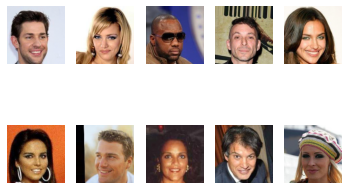

In [5]:
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_arr[i])
    plt.axis('off')
plt.show()

In [6]:
import tensorflow as tf

In [7]:
LATENT_DIM = 32
CHANNELS = 3
def generator_model():
    gen_input = tf.keras.layers.Input(shape=(LATENT_DIM, ))
    x = tf.keras.layers.Dense(128 * 16 * 16)(gen_input)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Reshape((16, 16, 128))(x)
    
    x = tf.keras.layers.Conv2D(256, 5, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv2D(512, 5, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv2D(512, 5, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)
    
    generator = tf.keras.models.Model(gen_input, x)
    return generator

In [8]:
def discriminator_model():
    disc_input = tf.keras.layers.Input(shape=(HEIGHT, WIDTH, CHANNELS))
    
    x = tf.keras.layers.Conv2D(256, 3)(disc_input)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv2D(256, 4, strides=2)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv2D(256, 4, strides=2)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv2D(256, 4, strides=2)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv2D(256, 4, strides=2)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    discriminator_model = tf.keras.models.Model(disc_input, x)
    
    optimizer = tf.keras.optimizers.RMSprop(lr=0.0001, clipvalue=1.0, decay=1e-8)
    discriminator_model.compile(optimizer=optimizer, loss='binary_crossentropy')
    
    return discriminator_model


In [9]:
generator_model = generator_model()
discriminator_model = discriminator_model()
discriminator_model.trainable = False
gan_input = tf.keras.layers.Input(shape=(LATENT_DIM))
gan_output = discriminator_model(generator_model(gan_input))
gan_model = tf.keras.models.Model(gan_input, gan_output)
optimizer = tf.keras.optimizers.RMSprop(lr=0.0001, clipvalue=1.0, decay=1e-8)
gan_model.compile(optimizer=optimizer, loss='binary_crossentropy')

2022-01-27 12:20:23.638336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 12:20:23.733704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 12:20:23.734436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 12:20:23.736216: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
gan_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
model (Functional)           (None, 128, 128, 3)       14953987  
_________________________________________________________________
model_1 (Functional)         (None, 1)                 4211713   
Total params: 19,165,700
Trainable params: 14,953,987
Non-trainable params: 4,211,713
_________________________________________________________________


In [11]:
import time
iters = 15000
batch_size = 16
RES_DIR = 'res2'
FILE_PATH = "{}/generated_{}.png"
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)
    
CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size = (CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses_list = []
a_losses_list = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    #generator takes random latent vector and should generate an image from it
    generated_arr = generator_model.predict(latent_vectors)
    
    #take images batch wise from the arr
    real_arr = image_arr[start : start + batch_size]
    combined_images_arr = np.concatenate([generated_arr, real_arr])
    
    #since we concatenate generated, real, labels should also reflect the same
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape)
    
    #we train discriminator individually
    d_loss = discriminator_model.train_on_batch(combined_images_arr, labels)
    d_losses_list.append(d_loss)
    
    #in adversarial network, discriminator model is not being trained, only generator
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))
    
    a_loss = gan_model.train_on_batch(latent_vectors, misleading_targets)
    a_losses_list.append(a_loss)
    
    start += batch_size
    if start > image_arr.shape[0] - batch_size:
        start = 0
    
    if step % 50 == 49:
        gan_model.save_weights('gan.h5')
        
        print("{}/{}: d_loss: {}, a_loss: {}, {}".format(step, iters, d_loss, a_loss, round(time.time() - start_time, 2)))
        
        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator_model.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT**2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH : (x_off + 1) * WIDTH, y_off * HEIGHT : (y_off + 1) * HEIGHT] = \
                control_generated[i, :, :, :]
        
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH.format(RES_DIR, images_saved))
        images_saved += 1

2022-01-27 12:20:26.903691: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-27 12:20:28.475297: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


49/15000: d_loss: 0.5814467668533325, a_loss: 0.642386794090271, 1.08
99/15000: d_loss: 0.6235918998718262, a_loss: 0.8403469920158386, 1.28
149/15000: d_loss: 0.6386004090309143, a_loss: 0.871706485748291, 1.12
199/15000: d_loss: 0.5825485587120056, a_loss: 0.8641360998153687, 1.26
249/15000: d_loss: 0.6694854497909546, a_loss: 0.8433786034584045, 1.27
299/15000: d_loss: 0.6255241632461548, a_loss: 0.8979302644729614, 1.11
349/15000: d_loss: 0.7483131885528564, a_loss: 1.143664836883545, 1.27
399/15000: d_loss: 0.629526674747467, a_loss: 0.9447287321090698, 1.31
449/15000: d_loss: 0.7332776784896851, a_loss: 0.736042857170105, 1.29
499/15000: d_loss: 0.6763893365859985, a_loss: 0.847078263759613, 1.11
549/15000: d_loss: 0.6403329372406006, a_loss: 0.8131864070892334, 1.11
599/15000: d_loss: 0.6928050518035889, a_loss: 0.8524771928787231, 1.26
649/15000: d_loss: 0.6643053293228149, a_loss: 0.9601057171821594, 1.26
699/15000: d_loss: 0.7002525329589844, a_loss: 0.8599565625190735, 1.26


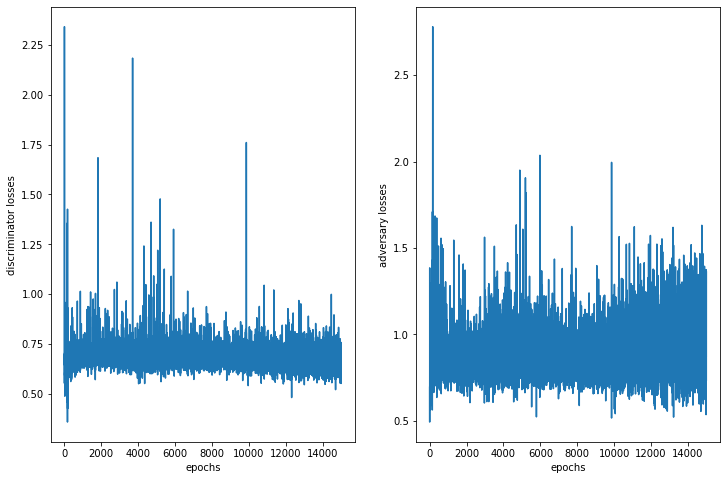

In [12]:
plt.figure(1, figsize=(12, 8))

plt.subplot(121)
plt.plot(d_losses_list)
plt.xlabel('epochs')
plt.ylabel('discriminator losses')

plt.subplot(122)
plt.plot(a_losses_list)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()


In [13]:
import imageio
import shutil
import os
images_to_gif = []
for filename in os.listdir('res2'):
    images_to_gif.append(imageio.imread("{}/{}".format(RES_DIR, filename)))
imageio.mimsave('visual.gif', images_to_gif)
shutil.rmtree(RES_DIR)